# Cài .venv chứa các thư viện

# Vacuum World — Vẽ cây tìm kiếm (Search Tree)

> Yêu cầu: vẽ cây tìm kiếm bắt đầu từ trạng thái ban đầu, số lượng trạng thái tối thiểu **10** và tối đa **30**. Có thể sinh ngẫu nhiên một số nhánh nhưng phải đúng Transition Function.

## Mô hình bài toán
- Môi trường: lưới $n \times n$
- Trạng thái: vị trí robot $(x,y)$ và ma trận bụi (dirty/clean)
- Hành động (Transition Function): `LEFT`, `RIGHT`, `UP`, `DOWN`, `SUCK`
  - Di chuyển chỉ hợp lệ nếu không ra ngoài biên
  - `SUCK` chỉ hợp lệ nếu ô hiện tại đang bẩn

In [2]:
%pip install networkx

  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
Using cached networkx-3.6.1-py3-none-any.whl (2.1 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 2 — Import & cấu hình
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import random
import math
import networkx as nx
import matplotlib.pyplot as plt

# Đổi seed để sinh cây khác nhau
SEED = 42
random.seed(SEED)


In [3]:
# Cell 3 — Định nghĩa Vacuum World + Transition Function
Action = str

@dataclass(frozen=True)
class State:
    robot_x: int
    robot_y: int
    dirt: Tuple[Tuple[int, ...], ...]  # 1=bẩn, 0=sạch (immutable để hash)

    @property
    def n(self) -> int:
        return len(self.dirt)

    def is_dirty_at_robot(self) -> bool:
        return self.dirt[self.robot_y][self.robot_x] == 1

    def dirt_count(self) -> int:
        return sum(sum(row) for row in self.dirt)


def grid_to_tuple(grid: List[List[bool]]) -> Tuple[Tuple[int, ...], ...]:
    return tuple(tuple(1 if cell else 0 for cell in row) for row in grid)


class VacuumWorld:
    ACTIONS: Tuple[Action, ...] = ("LEFT", "RIGHT", "UP", "DOWN", "SUCK")

    def __init__(self, n: int, start_x: int, start_y: int, dirt_grid: List[List[bool]]):
        self.n = n
        self.initial_state = State(start_x, start_y, grid_to_tuple(dirt_grid))

    def is_goal(self, s: State) -> bool:
        return s.dirt_count() == 0

    def valid_actions(self, s: State) -> List[Action]:
        acts: List[Action] = []
        if s.robot_x > 0:
            acts.append("LEFT")
        if s.robot_x < self.n - 1:
            acts.append("RIGHT")
        if s.robot_y > 0:
            acts.append("UP")
        if s.robot_y < self.n - 1:
            acts.append("DOWN")
        if s.is_dirty_at_robot():
            acts.append("SUCK")
        return acts

    def apply(self, s: State, a: Action) -> State:
        # Transition Function: di chuyển trong biên, SUCK làm sạch ô hiện tại
        x, y = s.robot_x, s.robot_y
        dirt = [list(row) for row in s.dirt]
        if a == "LEFT" and x > 0:
            x -= 1
        elif a == "RIGHT" and x < self.n - 1:
            x += 1
        elif a == "UP" and y > 0:
            y -= 1
        elif a == "DOWN" and y < self.n - 1:
            y += 1
        elif a == "SUCK":
            dirt[s.robot_y][s.robot_x] = 0
        else:
            # Nếu action không hợp lệ (không nên xảy ra nếu dùng valid_actions), giữ nguyên
            pass
        return State(x, y, tuple(tuple(row) for row in dirt))


@dataclass
class TreeNode:
    node_id: int
    state: State
    action: Optional[Action]
    depth: int
    parent_id: Optional[int]
    is_start: bool = False
    is_goal: bool = False
    children: List[int] = None  # list node_id


In [4]:
# Cell 4 — Sinh cây tìm kiếm (10–30 node) có ngẫu nhiên nhưng đúng Transition Function
def clamp(v: int, lo: int, hi: int) -> int:
    return max(lo, min(hi, v))


def generate_search_tree(
    env: VacuumWorld,
    node_limit: int = 20,
    *,
    min_nodes: int = 10,
    max_nodes: int = 30,
    max_depth: int = 7,
    duplicate_prob: float = 0.30,
    max_state_repeats: int = 2,
) -> Dict[int, TreeNode]:
    """
    Trả về dict node_id -> TreeNode. Cấu trúc luôn là *cây* (mỗi node có đúng 1 cha),
    nhưng có thể chứa các trạng thái trùng nhau (duplicate) để tạo thêm nhánh (có kiểm soát).
    """
    node_limit = clamp(node_limit, min_nodes, max_nodes)

    nodes: Dict[int, TreeNode] = {}
    root = TreeNode(
        node_id=0,
        state=env.initial_state,
        action=None,
        depth=0,
        parent_id=None,
        is_start=True,
        is_goal=env.is_goal(env.initial_state),
        children=[],
    )
    nodes[0] = root

    # BFS frontier
    queue: List[int] = [0]

    # Đếm số lần gặp mỗi state để giới hạn duplicate
    state_counts: Dict[State, int] = {env.initial_state: 1}

    next_id = 1
    while queue and next_id < node_limit:
        current_id = queue.pop(0)
        current = nodes[current_id]
        if current.depth >= max_depth:
            continue

        actions = env.valid_actions(current.state)
        random.shuffle(actions)

        # Có thể cắt bớt số nhánh từ 1 node để cây đỡ "nở" quá nhanh
        # (nhưng vẫn giữ tính hợp lệ vì luôn dùng valid_actions)
        max_branch_here = random.randint(1, max(1, len(actions)))
        actions = actions[:max_branch_here]

        for a in actions:
            if next_id >= node_limit:
                break

            new_state = env.apply(current.state, a)
            seen = state_counts.get(new_state, 0)
            allow = (seen == 0) or (seen < max_state_repeats and random.random() < duplicate_prob)

            if not allow:
                continue

            state_counts[new_state] = seen + 1
            child = TreeNode(
                node_id=next_id,
                state=new_state,
                action=a,
                depth=current.depth + 1,
                parent_id=current_id,
                is_start=False,
                is_goal=env.is_goal(new_state),
                children=[],
            )
            nodes[next_id] = child
            nodes[current_id].children.append(next_id)

            # Nếu là goal thì vẫn thêm vào cây, nhưng không cần mở rộng tiếp (tùy chọn)
            if not child.is_goal:
                queue.append(next_id)

            next_id += 1

        # Nếu queue cạn mà chưa đủ node, "bơm" lại bằng cách mở rộng từ các node hiện có
        if not queue and next_id < node_limit:
            expandable = [nid for nid, n in nodes.items() if n.depth < max_depth and not n.is_goal]
            random.shuffle(expandable)
            queue.extend(expandable[: max(1, len(expandable)//2)])

    return nodes


def tree_stats(nodes: Dict[int, TreeNode]) -> Dict[str, int]:
    max_depth = max(n.depth for n in nodes.values())
    goal_nodes = sum(1 for n in nodes.values() if n.is_goal)
    return {"total_nodes": len(nodes), "max_depth": max_depth, "goal_nodes": goal_nodes}


In [5]:
# Cell 5 — Chuyển cây sang graph + vẽ (matplotlib)
def build_nx_graph(nodes: Dict[int, TreeNode]) -> nx.DiGraph:
    g = nx.DiGraph()
    for nid, n in nodes.items():
        g.add_node(nid, depth=n.depth, is_start=n.is_start, is_goal=n.is_goal, action=n.action)
        if n.parent_id is not None:
            g.add_edge(n.parent_id, nid, action=n.action)
    return g


def _tree_children(nodes: Dict[int, TreeNode]) -> Dict[int, List[int]]:
    return {nid: list(n.children or []) for nid, n in nodes.items()}


def tidy_tree_positions(nodes: Dict[int, TreeNode]) -> Dict[int, Tuple[float, float]]:
    """
    Layout kiểu "tidy tree" đơn giản:
    - y theo depth
    - x theo thứ tự DFS của lá (giảm chồng chéo, dễ nhìn hơn layout theo tầng thuần)
    """
    children = _tree_children(nodes)
    x_counter = 0
    pos: Dict[int, Tuple[float, float]] = {}

    def dfs(nid: int) -> float:
        nonlocal x_counter
        kids = children.get(nid, [])
        if not kids:
            x_counter += 1
            x = float(x_counter)
            pos[nid] = (x, -nodes[nid].depth)
            return x
        xs = [dfs(k) for k in kids]
        x = sum(xs) / len(xs)
        pos[nid] = (x, -nodes[nid].depth)
        return x

    dfs(0)
    return pos


def draw_state_grid(state: State, ax: plt.Axes, title: str = "") -> None:
    n = state.n
    # 0=sạch, 1=bẩn
    grid = [[state.dirt[y][x] for x in range(n)] for y in range(n)]
    ax.imshow(grid, cmap="copper", vmin=0, vmax=1)
    # Robot marker
    ax.scatter([state.robot_x], [state.robot_y], c="red", s=180, marker="o", edgecolors="white", linewidths=1.5)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(range(n))
    ax.set_yticklabels(range(n))
    ax.grid(True, color="white", alpha=0.25, linewidth=0.8)
    ax.set_title(title, fontsize=10)
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(n - 0.5, -0.5)  # giữ y tăng xuống như ma trận
    ax.set_aspect("equal")


def draw_tree(nodes: Dict[int, TreeNode], *, seed: int, figsize=None) -> None:
    """
    Vẽ 1 hình gồm 2 phần:
    - Trái: cây tìm kiếm (dễ nhìn hơn, có legend + ghi chú)
    - Phải: trạng thái gốc (để đối chiếu nhanh)
    """
    g = build_nx_graph(nodes)
    pos = tidy_tree_positions(nodes)

    # Chuẩn hóa x để cây không quá rộng khi node nhiều
    xs = [p[0] for p in pos.values()]
    min_x, max_x = min(xs), max(xs)
    span_x = max(1.0, max_x - min_x)
    pos = {nid: ((x - min_x) / span_x, y) for nid, (x, y) in pos.items()}

    # Tự scale figsize theo số node và độ sâu
    if figsize is None:
        depth_max = max(n.depth for n in nodes.values())
        width = min(22, 10 + len(nodes) * 0.45)
        height = min(10, 5 + depth_max * 0.9)
        figsize = (width, height)

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[3.2, 1.2])
    ax_tree = fig.add_subplot(gs[0, 0])
    ax_state = fig.add_subplot(gs[0, 1])

    # Màu node
    node_colors = []
    for nid in g.nodes():
        n = nodes[nid]
        if n.is_start:
            node_colors.append("#7c3aed")  # start
        elif n.is_goal:
            node_colors.append("#10b981")  # goal
        else:
            node_colors.append("#3b82f6")  # normal

    # Vẽ cạnh + node
    nx.draw_networkx_edges(g, pos, ax=ax_tree, arrows=False, width=1.3, alpha=0.40)
    nx.draw_networkx_nodes(
        g, pos, ax=ax_tree, node_color=node_colors, node_size=900, linewidths=1.4, edgecolors="white"
    )

    # Label node: id + D + (x,y)
    labels = {
        nid: f"{nid}\nD={nodes[nid].state.dirt_count()}\n({nodes[nid].state.robot_x},{nodes[nid].state.robot_y})"
        for nid in g.nodes()
    }
    nx.draw_networkx_labels(g, pos, ax=ax_tree, labels=labels, font_size=7.5, font_color="white")

    # Label cạnh: action (có nền để dễ đọc)
    edge_labels = {(u, v): (g.edges[u, v].get("action") or "") for u, v in g.edges()}
    nx.draw_networkx_edge_labels(
        g,
        pos,
        ax=ax_tree,
        edge_labels=edge_labels,
        font_size=8,
        label_pos=0.5,
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.70),
    )

    # Legend + chú thích
    from matplotlib.patches import Patch
    legend_items = [
        Patch(facecolor="#7c3aed", edgecolor="white", label="Start (gốc)"),
        Patch(facecolor="#3b82f6", edgecolor="white", label="Trung gian"),
        Patch(facecolor="#10b981", edgecolor="white", label="Goal (hết bụi)"),
    ]
    ax_tree.legend(handles=legend_items, loc="upper left", frameon=True, framealpha=0.85)

    ax_tree.set_title(
        "Vacuum World — Search Tree (bắt đầu từ trạng thái ban đầu)\n"
        "Ghi chú: Node label = id / D (số ô bụi còn lại) / (x,y). Edge label = action.\n"
        f"Seed={seed}, Total={len(nodes)}",
        fontsize=11,
    )
    ax_tree.axis("off")

    # Panel trạng thái gốc
    root = nodes[0]
    draw_state_grid(
        root.state,
        ax_state,
        title=f"Trạng thái gốc (node 0)\nRobot=({root.state.robot_x},{root.state.robot_y}), D={root.state.dirt_count()}",
    )

    fig.tight_layout()
    plt.show()


def draw_state_gallery(nodes: Dict[int, TreeNode], node_ids: List[int], cols: int = 3, figsize=(12, 8)) -> None:
    """Vẽ nhiều trạng thái dạng gallery để xem chi tiết dễ hơn."""
    node_ids = [nid for nid in node_ids if nid in nodes]
    if not node_ids:
        print("Không có node nào để vẽ gallery.")
        return
    rows = math.ceil(len(node_ids) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [list(axes)]
    else:
        axes = [list(r) for r in axes]

    for i, nid in enumerate(node_ids):
        r, c = divmod(i, cols)
        ax = axes[r][c]
        n = nodes[nid]
        act = n.action if n.action is not None else "—"
        title = f"node {nid} | depth={n.depth} | act={act}\nRobot=({n.state.robot_x},{n.state.robot_y}) | D={n.state.dirt_count()}"
        draw_state_grid(n.state, ax, title=title)

    # Tắt các ô thừa
    for j in range(len(node_ids), rows * cols):
        r, c = divmod(j, cols)
        axes[r][c].axis("off")

    fig.suptitle("Vacuum World — State Gallery (chi tiết một số trạng thái)", fontsize=12)
    fig.tight_layout()
    plt.show()


Stats: {'total_nodes': 15, 'max_depth': 6, 'goal_nodes': 1}


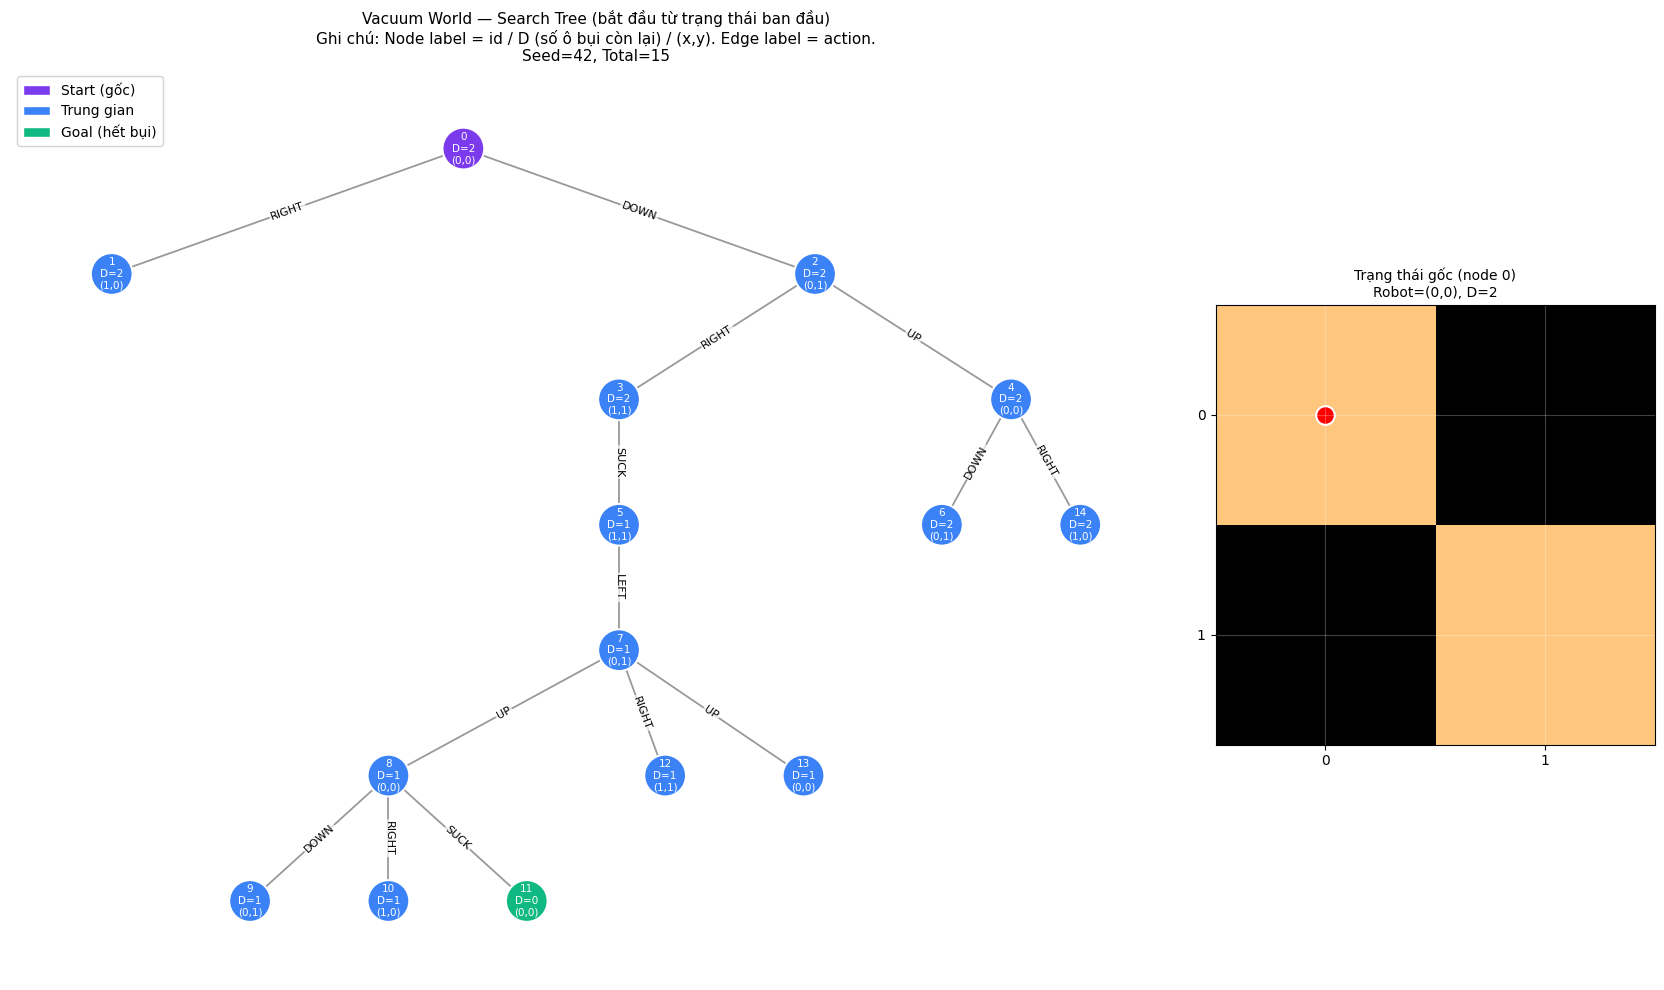

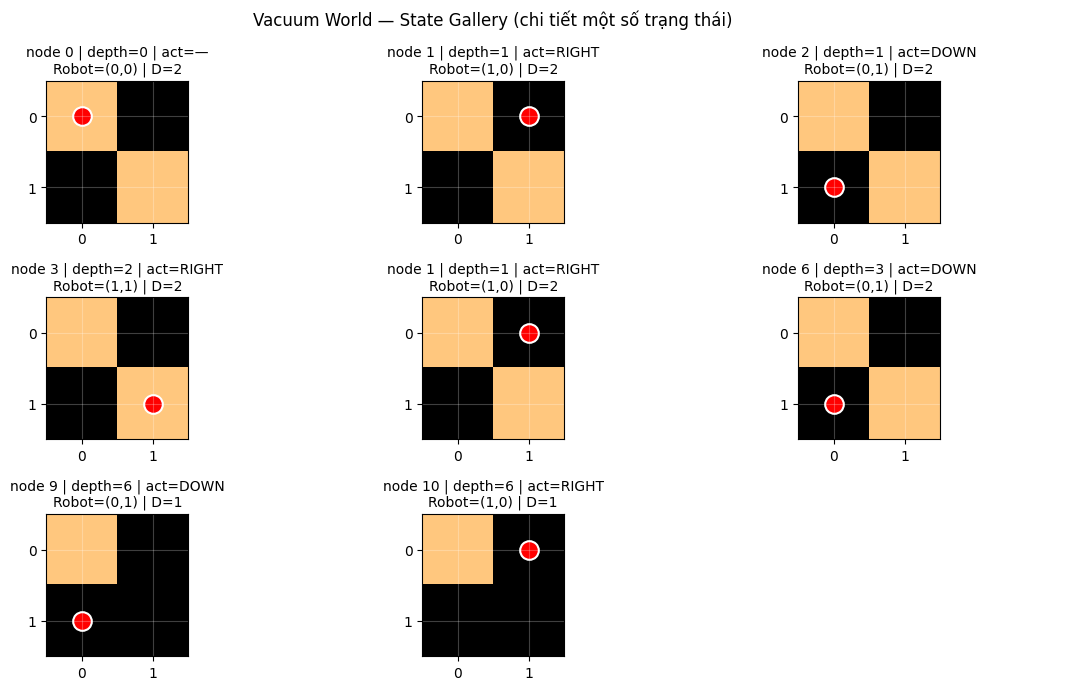

In [ ]:
# Cell 6 — Khởi tạo trạng thái ban đầu + sinh & vẽ cây (10–30 node)
# Bạn có thể đổi N, vị trí robot, và lưới bụi bên dưới
N = 2  # Kích thước lưới N x N
start_x, start_y = 0, 0

# Ví dụ phân bố bụi (True=bẩn, False=sạch)
dirt_grid = [
    # [True,  False, True],
    # [False, True,  False],
    # [True,  False, True],
    # Gợi ý: thêm nhiều bụi hơn để dễ xuất hiện goal sau vài bước
    # [True, True],
    # [True, True],
    [True, False],
    [False, True],
]

env = VacuumWorld(N, start_x, start_y, dirt_grid)

# Chọn số node muốn vẽ (tự động clamp vào [10,30])
NODE_LIMIT = 20
nodes = generate_search_tree(env, NODE_LIMIT, min_nodes=10, max_nodes=30)
print("Stats:", tree_stats(nodes))

# 1) Hình cây + chú thích + panel trạng thái gốc
draw_tree(nodes, seed=SEED)

# 2) Gallery trạng thái (chọn vài node tiêu biểu để xem chi tiết)
all_ids = sorted(nodes.keys())
leaf_ids = [nid for nid in all_ids if len(nodes[nid].children or []) == 0]
sample_ids = [0] + all_ids[1:4] + leaf_ids[:4]  # root + vài node đầu + vài lá
draw_state_gallery(nodes, sample_ids, cols=3, figsize=(12, 7))


## Gợi ý thử nghiệm nhanh
- Đổi `NODE_LIMIT` trong khoảng 10–30 (hoặc để ngoài khoảng cũng được, code sẽ tự ép về 10–30).
- Đổi `SEED` để tạo cây khác nhau (ngẫu nhiên nhánh nhưng vẫn đúng Transition Function).
- Đổi `dirt_grid` hoặc `N` để so sánh mức độ nở cây theo kích thước môi trường.
